In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from numpy import asarray
import shapefile

In [2]:
# Imagenes que vamos a comparar
# original
IMAGE_ORI = '689795.95_4197188.34_690051.95_4197444.34.png'
# imagen predicha
IMAGE_PRE = 'foto2.png' 

In [3]:
# Creamos un shapefile temporal 
%run gdal_polygonize.py 689795.95_4197188.34_690051.95_4197444.34.png -f "ESRI Shapefile" temp/original.shp
%run gdal_polygonize.py foto2.png -f "ESRI Shapefile" temp/prediccion1.shp

In [4]:
# Creamos arrays con los datos de las imagenes
imagen_original = Image.open(IMAGE_ORI)
data_original = asarray(imagen_original)
imagen_predicha = Image.open(IMAGE_PRE)
data_predicha = asarray(imagen_predicha)

In [5]:
#Calcula el IOU de 2 BBOX

def bb_intersection_over_union(boxA, boxB):
# determina coordenadas (x, y)-del rectangulo de interseccion
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # calcula el area del rectangulo
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # calcula el área de la predicción y la rectangulo de la zona correcta
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = round(interArea / float(boxAArea + boxBArea - interArea),2)
    # devuelve iou
    return iou

In [6]:
def obtener_bbox(shp):
    bbox=[]
    #leemos el shapefile
    sf  = shapefile.Reader(shp)
    #obtenemos los poligonos del shapefile
    shapes = sf.shapes()
    #Obtenemos el bbox para cada poliigono
    for n in range(0, len(shapes)):
        cuadro=shapes[n].bbox
        cuadro=[int(round(float(i))) for i in cuadro]
        bbox.append(cuadro)
    return (bbox)

In [7]:
def iou_maximo(boxA,boxB):
    #Array para guardar iou y posicion box de cruce 
    iou = []
    posicion = []
    #Recorremos todass las cajas
    for ii in range (0, len(boxA)):
        iou_temp=[]
        for jj in range (0, len(boxB)):
            #calculamos iou entre cajas
            iou_temp.append(bb_intersection_over_union(boxA[ii], boxB[jj]))
        #Si el valor es 0, no hay cruce y posicion -1
        #Si cruza, decuelve el valor iou y posicion de cruce
        if (max(iou_temp) == 0):
            posicion.append(-1)
            iou.append(0)
        else:
            posicion.append(iou_temp.index(max(iou_temp)))
            iou.append(max(iou_temp))
    #devuelve vectores iou maximas y posicion box cruce
    return (iou,posicion)
            

In [8]:
def caracteristicas(boxA):
    ancho = [] 
    alto = []
     #Recorremos todas las cajas
    for ii in range (0, len(boxA)):
        ancho.append(boxA[ii][2] - boxA[ii][0])
        alto.append(boxA[ii][3] - boxA[ii][1])
    return(alto,ancho)

In [9]:
def acc(boxA):
    acc=[]
    for ii in range (0, len(boxA)):
        c=0
        recorte_original = data_original[boxA[ii][1]:boxA[ii][3], boxA[ii][0]:boxA[ii][2]]
        recorte_predicho = data_predicha[boxA[ii][1]:boxA[ii][3], boxA[ii][0]:boxA[ii][2]]
        for yy in range (0,recorte_original.shape[0]):
            for xx in range (0,recorte_original.shape[1]):
                if (recorte_original[yy][xx]==recorte_predicho[yy][xx]):
                    c=c+1
        area=recorte_original.shape[0]*recorte_original.shape[1]
        acc.append((c/area)*100) 
        
    return(acc)

In [10]:
def pixel_accuraccy(bboxA):
   
    imagen = Image.open(IMAGE_ORI)
    ima = asarray(imagen)
    imagen_predicha = Image.open(IMAGE_PRE)
    ima_com = asarray(imagen_predicha)
    
    accu=[]
    for n in range(0,len(bbox)):
        acierto=0
    
        area=int((bboxA[n][2]-bboxA[n][0])*(bboxA[n][3]-bboxA[n][1]))
        for x in range (int(bboxA[n][0]),int(bboxA[n][2])):
            for y in range (int(bboxA[n][1]),int(bboxA[n][3])):
                if (ima[y][x][0]==ima_com[y][x][0]):
                    acierto=acierto+1
        accu.append((acierto/area)*100)
                
    return (accu)

In [11]:
def pixel_blanco(datos,box):
    blancos=[]
    for bb in range (0, len(box)):
        recorte=datos[box[bb][1]:box[bb][3], box[bb][0]:box[bb][2]]
        blancos.append(np.count_nonzero(recorte)*(0.25*0.25)) 
    return(blancos)

In [12]:
def color_pixel(datos,x,y):
    return(datos[x:y:0])

In [13]:
def crear_imagen(imagen,box,lista,col):

    im=cv2.imread(imagen)
    #print(im)
    for nn in range(0,len(lista)):
        #print(lista[nn])
        topleft_x,topleft_y,bottom_right_x,bottom_right_y= box[lista[nn]]
        cv2.rectangle(im,(topleft_x, topleft_y),(bottom_right_x, bottom_right_y),color=col, thickness=2)    
    return(im)

In [14]:
df_original = pd.DataFrame(columns = ('BBOX', 'ANCHO', 'ALTO', 'IOU', 'BOX_CRUCE', 'ACC', 'SUPERFICIE','BLANCOS_INV', 'ESTADO'))
df_predicho = pd.DataFrame(columns = ('BBOX', 'ANCHO', 'ALTO', 'IOU', 'BOX_CRUCE', 'ACC', 'SUPERFICIE','BLANCOS_INV', 'ESTADO'))

In [15]:
df_original['BBOX'] = bbox_original = obtener_bbox("temp/original.shp")
df_predicho['BBOX'] = bbox_predicho = obtener_bbox("temp/prediccion1.shp")


In [16]:
df_original['IOU'], df_original['BOX_CRUCE'] = iou_maximo(bbox_original, bbox_predicho)
df_predicho['IOU'], df_predicho['BOX_CRUCE'] = iou_maximo(bbox_predicho, bbox_original)

In [17]:
df_original['ALTO'], df_original['ANCHO'] = caracteristicas(bbox_original)
df_predicho['ALTO'], df_predicho['ANCHO'] = caracteristicas(bbox_predicho)

In [18]:
df_original['SUPERFICIE']=pixel_blanco(data_original,bbox_original)
df_predicho['SUPERFICIE']=pixel_blanco(data_predicha,bbox_predicho)
df_original['BLANCOS_INV']=pixel_blanco(data_predicha,bbox_original)
df_predicho['BLANCOS_INV']=pixel_blanco(data_original,bbox_predicho)

In [19]:
df_original['ACC']=acc(bbox_original)
df_predicho['ACC']=acc(bbox_predicho)

In [20]:
df_original.head()


,BBOX,ANCHO,ALTO,IOU,BOX_CRUCE,ACC,SUPERFICIE,BLANCOS_INV,ESTADO
0,"[244, 0, 265, 8]",21,8,0.00,-1,42.857143,6.0000,0.0000,NaN
1,"[114, 0, 161, 24]",47,24,0.87,3,83.333333,50.5000,55.2500,NaN
2,"[108, 15, 147, 45]",39,30,0.84,4,72.051282,46.8750,44.3125,NaN
3,"[0, 9, 50, 55]",50,46,0.52,5,37.695652,87.8125,61.3750,NaN
4,"[188, 7, 257, 71]",69,64,0.82,6,85.937500,140.6250,149.5625,NaN


In [21]:
df_predicho.head()

,BBOX,ANCHO,ALTO,IOU,BOX_CRUCE,ACC,SUPERFICIE,BLANCOS_INV,ESTADO
0,"[476, 0, 493, 2]",17,2,0.00,-1,14.705882,1.8125,0.0,NaN
1,"[495, 0, 496, 1]",1,1,0.00,-1,0.000000,0.0625,0.0,NaN
2,"[284, 0, 314, 20]",30,20,0.00,-1,36.000000,24.0000,0.0,NaN
3,"[115, 0, 159, 26]",44,26,0.87,1,82.167832,57.8750,52.5,NaN
4,"[108, 17, 143, 45]",35,28,0.84,2,72.653061,40.0000,42.0,NaN


In [22]:
df_predicho['SUPERFICIE'].iloc[1]

0.0625

In [23]:
image_ori_bbox = cv2.imread(IMAGE_ORI)
image_pre_bbox = cv2.imread(IMAGE_PRE)

for n in range(0, len(bbox_original)):
    topleft_x, topleft_y, bottom_right_x, bottom_right_y = bbox_original[n]
    cv2.rectangle(image_ori_bbox,
                  (topleft_x, topleft_y),
                  (bottom_right_x, bottom_right_y),
                  color=(0, 255, 0), 
                  thickness=1)
    cv2.putText(image_ori_bbox, str(n), (topleft_x, topleft_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    cv2.rectangle(image_pre_bbox,(topleft_x, topleft_y),(bottom_right_x, bottom_right_y),color=(0, 255, 0), thickness=1)
    cv2.putText(image_pre_bbox, str(n), (topleft_x, topleft_y),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)
    

for n in range(0,len(bbox_predicho)):
    topleft_x,topleft_y,bottom_right_x,bottom_right_y= bbox_predicho[n]
    
    cv2.rectangle(image_pre_bbox,(topleft_x, topleft_y),(bottom_right_x, bottom_right_y),color=(255, 0, 0), thickness=1)
    cv2.putText(image_pre_bbox, str(n), (topleft_x, topleft_y),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 2)
    cv2.rectangle(image_ori_bbox,(topleft_x, topleft_y),(bottom_right_x, bottom_right_y),color=(255, 0, 0), thickness=1)
    cv2.putText(image_ori_bbox, str(n), (topleft_x, topleft_y),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 2)


# Mostramos resultados 

Text(0.5, 1.0, 'Predicha bbox')

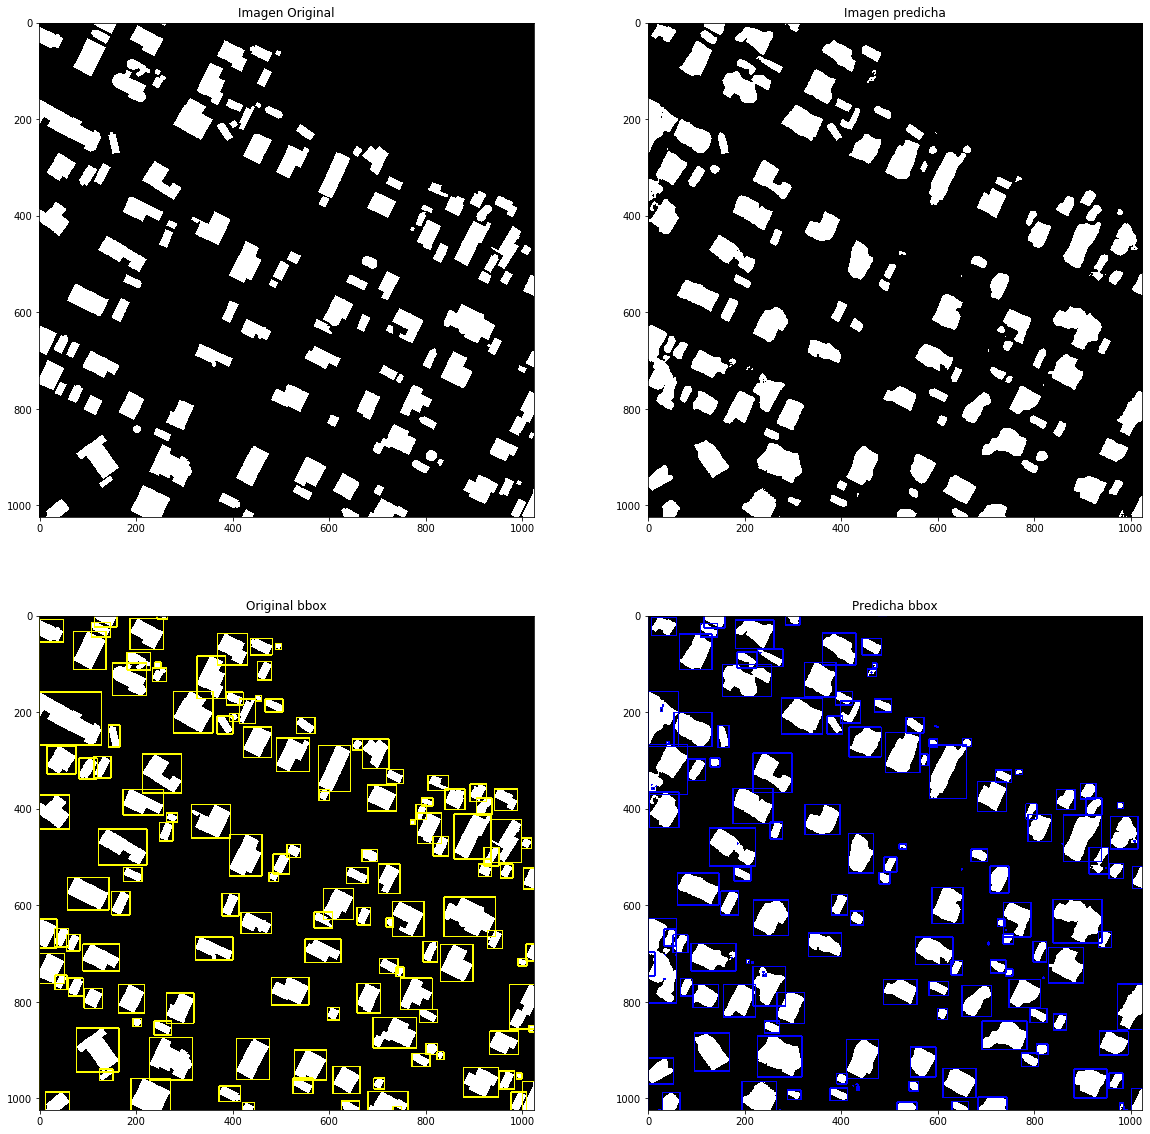

In [24]:
im_ori = image_ori_bbox=cv2.imread(IMAGE_ORI) 
im_pre = image_pre_bbox=cv2.imread(IMAGE_PRE)

imagen_original_bbox=crear_imagen(IMAGE_ORI,bbox_original,df_original.index,(255,255,0))
imagen_predicha_bbox=crear_imagen(IMAGE_PRE,bbox_predicho,df_predicho.index,(0,0,255))

plt.figure(figsize=(20,20))

plt.subplot(221)
plt.imshow(im_ori)
plt.title('Imagen Original')

plt.subplot(222)
plt.imshow(im_pre)
plt.title('Imagen predicha')

plt.subplot(223)
plt.imshow(imagen_original_bbox)
plt.title('Original bbox')

plt.subplot(224)
plt.imshow(imagen_predicha_bbox)
plt.title('Predicha bbox')

# IOU superior a 0.5

Text(0.5, 1.0, 'Imagen predicha IOU>0.5')

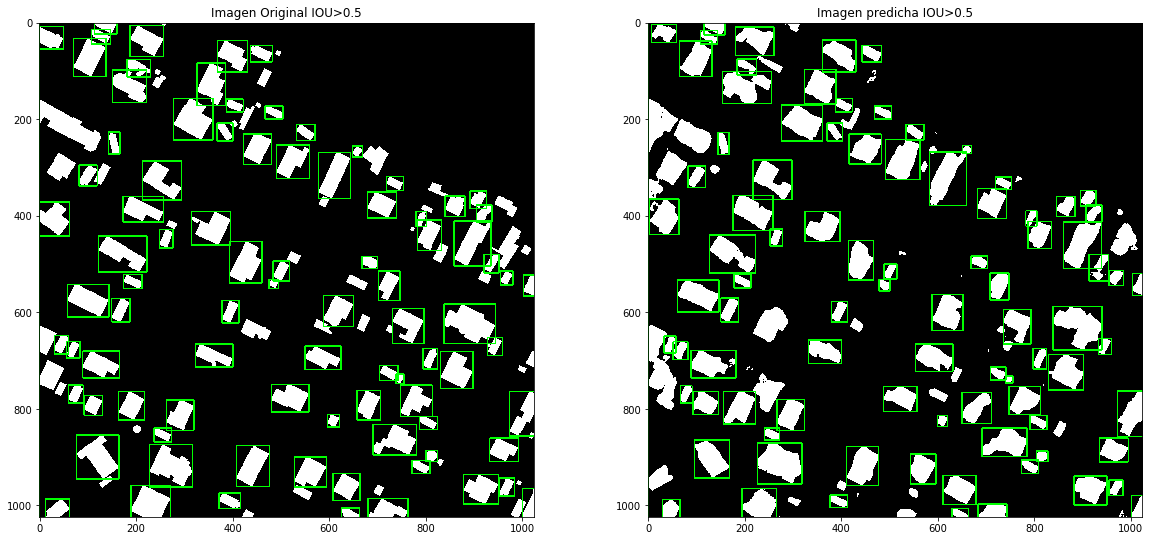

In [25]:
df_ori_iou=df_original.index[(df_original['IOU']>=0.5)]
df_pre_iou=df_predicho.index[(df_predicho['IOU']>=0.5)]

imagen_original_iou=crear_imagen(IMAGE_ORI,bbox_original,df_ori_iou,(0,255,0))
imagen_predicha_iou=crear_imagen(IMAGE_PRE,bbox_predicho,df_pre_iou,(0,255,0))

plt.figure(figsize=(20,20))

plt.subplot(221)
plt.imshow(imagen_original_iou)
plt.title('Imagen Original IOU>0.5')

plt.subplot(222)
plt.imshow(imagen_predicha_iou)
plt.title('Imagen predicha IOU>0.5')


# Construcciones de mas de 5m2 que no cruzan

Text(0.5, 1.0, 'Imagen predicha nuevas construcciones')

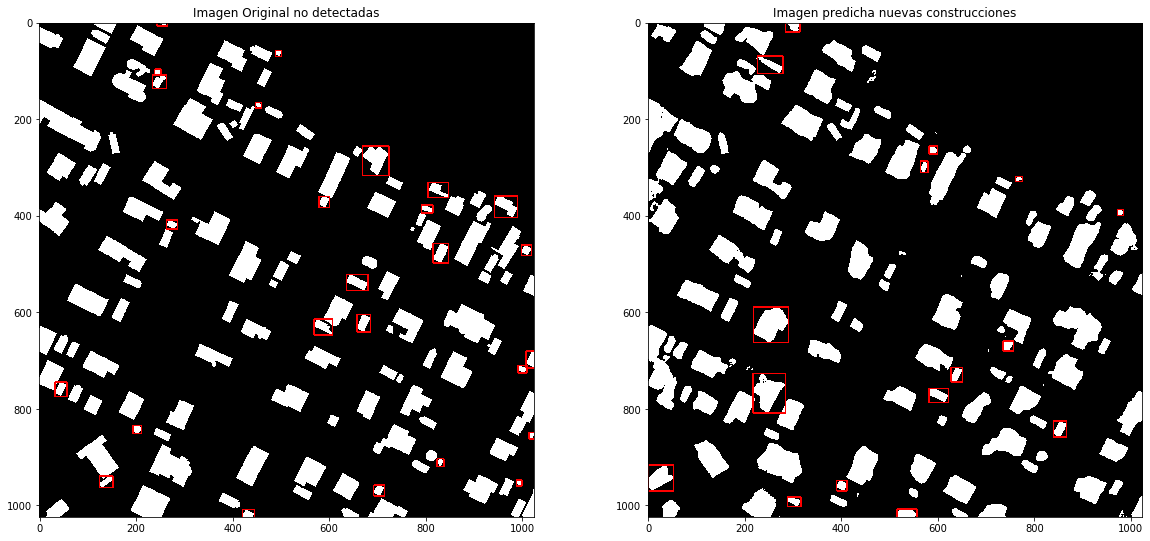

In [26]:
original_nocruza=df_original.index[((df_original['BLANCOS_INV']==0) | (df_original['IOU']<=0.1)) & (df_original['SUPERFICIE']>5) ]
predicho_nocruza=df_predicho.index[((df_predicho['BLANCOS_INV']==0) | (df_predicho['IOU']<=0.1)) & (df_predicho['SUPERFICIE']>5) ]

imagen_original_no=crear_imagen(IMAGE_ORI,bbox_original,original_nocruza,(255,0,0))
imagen_predicha_no=crear_imagen(IMAGE_PRE,bbox_predicho,predicho_nocruza,(255,0,0))

plt.figure(figsize=(20,20))

plt.subplot(221)
plt.imshow(imagen_original_no)
plt.title('Imagen Original no detectadas')

plt.subplot(222)
plt.imshow(imagen_predicha_no)
plt.title('Imagen predicha nuevas construcciones')


# Ampliaciones

In [27]:
resto_box=df_predicho.drop(df_pre_iou)
resto_box=resto_box.drop(predicho_nocruza)


Text(0.5, 1.0, 'Imagen predicha')

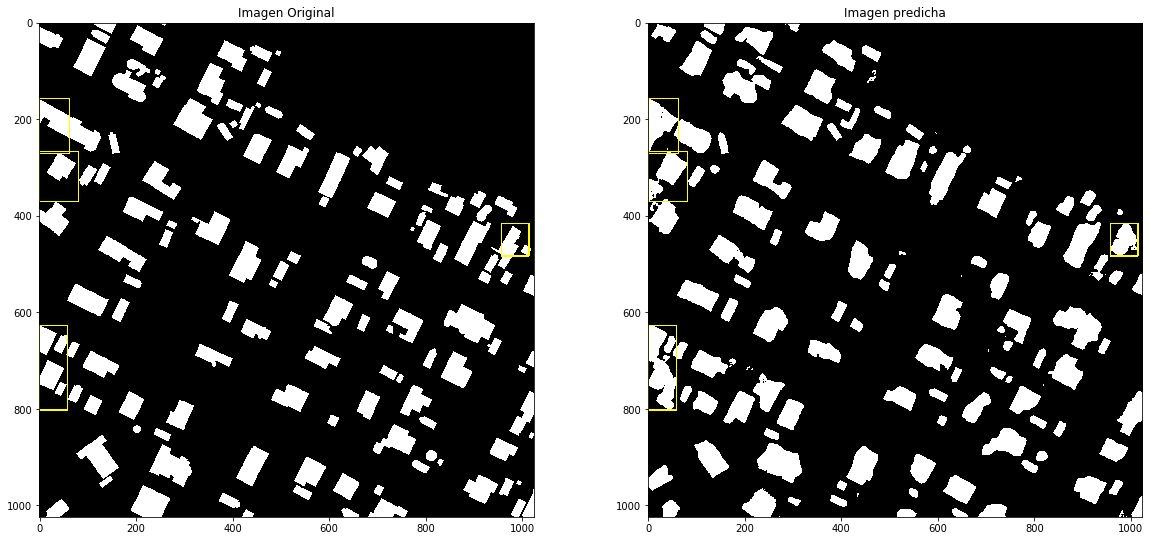

In [28]:
df_ampliacion=resto_box.index[((resto_box['BLANCOS_INV']*1.25)<resto_box['SUPERFICIE']) & (resto_box['SUPERFICIE']>5)]
df_ampliacion

imagen_original_ampliacion=crear_imagen(IMAGE_ORI,bbox_predicho,df_ampliacion,(255,255,0))
imagen_predicha_ampliacion=crear_imagen(IMAGE_PRE,bbox_predicho,df_ampliacion,(255,255,0))

plt.figure(figsize=(20,20))

plt.subplot(221)
plt.imshow(imagen_original_ampliacion)
plt.title('Imagen Original')

plt.subplot(222)
plt.imshow(imagen_predicha_ampliacion)
plt.title('Imagen predicha')



# Creacion csv con datos de salida

In [29]:
ampliaciones=df_ampliacion
nueva_construccion=predicho_nocruza
no_localizados=original_nocruza

In [30]:
xmin,ymin,xmax,ymax=IMAGE_ORI.split('_') 
float(ymax[:-4])
coord=[]
coord.append(['X','Y','ESTADO'])
for xx in range (0,len(df_ampliacion)):
    t=(bbox_predicho[df_ampliacion[xx]])
    x=float(xmin)+(t[0]+((t[2]-t[0])/2))*0.25
    y=float(ymax[:-4])-(t[1]+((t[3]-t[1])/2))*0.25
    coord.append([x,y,'AMPLIACION'])
for xx in range (0,len(predicho_nocruza)):
    t=(bbox_predicho[predicho_nocruza[xx]])
    x=float(xmin)+(t[0]+((t[2]-t[0])/2))*0.25
    y=float(ymax[:-4])-(t[1]+((t[3]-t[1])/2))*0.25
    coord.append([x,y,'NUEVA CONSTRUCCION'])
for xx in range (0,len(original_nocruza)):
    t=(bbox_original[original_nocruza[xx]])
    x=float(xmin)+(t[0]+((t[2]-t[0])/2))*0.25
    y=float(ymax[:-4])-(t[1]+((t[3]-t[1])/2))*0.25
    coord.append([x,y,'NO DETECTADAS'])
   

In [31]:
xmin,ymin,xmax,ymax


('689795.95', '4197188.34', '690051.95', '4197444.34.png')

In [32]:
4197188.34+28.25+(271*0.25)

4197284.34

In [33]:
coord

[['X', 'Y', 'ESTADO'],
 [689803.825, 4197390.715, 'AMPLIACION'],
 [689806.075, 4197364.59, 'AMPLIACION'],
 [690042.075, 4197331.84, 'AMPLIACION'],
 [689803.325, 4197265.715, 'AMPLIACION'],
 [689870.7, 4197441.84, 'NUEVA CONSTRUCCION'],
 [689859.075, 4197422.34, 'NUEVA CONSTRUCCION'],
 [689943.325, 4197378.215, 'NUEVA CONSTRUCCION'],
 [689938.7, 4197369.59, 'NUEVA CONSTRUCCION'],
 [689987.7, 4197363.215, 'NUEVA CONSTRUCCION'],
 [690040.2, 4197345.965, 'NUEVA CONSTRUCCION'],
 [689859.45, 4197287.965, 'NUEVA CONSTRUCCION'],
 [689982.2, 4197276.965, 'NUEVA CONSTRUCCION'],
 [689955.45, 4197262.09, 'NUEVA CONSTRUCCION'],
 [689946.2, 4197251.215, 'NUEVA CONSTRUCCION'],
 [689858.575, 4197252.465, 'NUEVA CONSTRUCCION'],
 [690008.825, 4197233.965, 'NUEVA CONSTRUCCION'],
 [689802.45, 4197208.59, 'NUEVA CONSTRUCCION'],
 [689896.075, 4197204.59, 'NUEVA CONSTRUCCION'],
 [689871.45, 4197196.34, 'NUEVA CONSTRUCCION'],
 [689929.825, 4197190.465, 'NUEVA CONSTRUCCION'],
 [689859.575, 4197443.34, 'NO ENCO

In [34]:
31.5*0.25


7.875

In [35]:
xmin,ymin,xmax,ymax


('689795.95', '4197188.34', '690051.95', '4197444.34.png')

In [36]:
689795.95-690051.95

-256.0

In [37]:
import csv
with open('coordendas3.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(coord)

In [38]:
xmin,ymin,xmax,ymax=IMAGE_ORI.split('_') 
float(ymax[:-4])

4197444.34

In [39]:
float(xmin)


689795.95

In [40]:
ndf=df_predicho.drop(df_pre_iou)
ndf2=ndf.drop(predicho_nocruza)
ndf2[ndf2['SUPERFICIE']>5]

,BBOX,ANCHO,ALTO,IOU,BOX_CRUCE,ACC,SUPERFICIE,BLANCOS_INV,ESTADO
17,"[454, 111, 472, 127]",18,16,0.28,11,53.819444,8.0000,16.3125,NaN
24,"[398, 177, 439, 223]",41,46,0.48,19,86.108165,57.0000,57.2500,NaN
32,"[0, 158, 63, 271]",63,113,0.48,23,75.319567,229.7500,171.6875,NaN
33,"[53, 201, 132, 272]",79,71,0.35,23,85.558923,204.9375,182.1875,NaN
38,"[128, 295, 148, 314]",20,19,0.25,30,80.000000,16.6250,18.5000,NaN
49,"[0, 267, 81, 371]",81,104,0.41,29,79.760209,222.3125,121.2500,NaN
66,"[956, 416, 1013, 484]",57,68,0.38,57,69.556244,141.8750,110.0000,NaN
67,"[519, 473, 534, 484]",15,11,0.21,54,64.848485,5.8125,6.9375,NaN
85,"[418, 612, 445, 641]",27,29,0.26,76,71.392082,29.3125,32.6875,NaN
86,"[722, 628, 738, 644]",16,16,0.48,74,52.734375,11.3125,9.6250,NaN


In [41]:
ndf2[((ndf2['BLANCOS_INV']*1.25)<ndf2['SUPERFICIE']) & (ndf2['SUPERFICIE']>5)]

,BBOX,ANCHO,ALTO,IOU,BOX_CRUCE,ACC,SUPERFICIE,BLANCOS_INV,ESTADO
32,"[0, 158, 63, 271]",63,113,0.48,23,75.319567,229.7500,171.6875,NaN
49,"[0, 267, 81, 371]",81,104,0.41,29,79.760209,222.3125,121.2500,NaN
66,"[956, 416, 1013, 484]",57,68,0.38,57,69.556244,141.8750,110.0000,NaN
119,"[0, 627, 59, 802]",59,175,0.32,92,74.605327,393.6875,277.3125,NaN


In [42]:
t=df_predicho.index[(df_predicho['SUPERFICIE']>5) & (df_predicho['IOU']==0)]

In [43]:
t=df_predicho.index[(df_predicho['SUPERFICIE']>5) & (df_predicho['BOX_CRUCE']==-1)]
df_predicho[(df_predicho['SUPERFICIE']>5) & (df_predicho['BOX_CRUCE']==-1)]

,BBOX,ANCHO,ALTO,IOU,BOX_CRUCE,ACC,SUPERFICIE,BLANCOS_INV,ESTADO
2,"[284, 0, 314, 20]",30,20,0.0,-1,36.000000,24.0000,0.0,NaN
41,"[760, 319, 774, 330]",14,11,0.0,-1,40.259740,5.7500,0.0,NaN
109,"[626, 714, 650, 744]",24,30,0.0,-1,39.305556,27.3125,0.0,NaN
116,"[581, 758, 621, 787]",40,29,0.0,-1,46.034483,39.1250,0.0,NaN
129,"[838, 825, 865, 858]",27,33,0.0,-1,43.434343,31.5000,0.0,NaN
139,"[0, 916, 52, 970]",52,54,0.0,-1,44.373219,97.6250,0.0,NaN
149,"[288, 982, 316, 1002]",28,20,0.0,-1,39.642857,21.1250,0.0,NaN
155,"[515, 1007, 556, 1024]",41,17,0.0,-1,16.786227,36.2500,0.0,NaN


In [44]:
#nuevos
t=df_predicho.index[(df_predicho['SUPERFICIE']>5) & (df_predicho['BOX_CRUCE']!=-1) & (df_predicho['IOU']<0.1) & (df_predicho['SUPERFICIE']>5)]
df_predicho.index[(df_predicho['SUPERFICIE']>5) & (df_predicho['BOX_CRUCE']!=-1) & (df_predicho['IOU']<0.1) & (df_predicho['SUPERFICIE']>5)]

Int64Index([12, 35, 39, 53, 88, 91, 121, 140], dtype='int64')

In [45]:
df_predicho[(df_predicho['SUPERFICIE']>5) & (df_predicho['BOX_CRUCE']!=-1) & (df_predicho['IOU']<0.5) & (df_predicho['BLANCOS_INV']>5)]

,BBOX,ANCHO,ALTO,IOU,BOX_CRUCE,ACC,SUPERFICIE,BLANCOS_INV,ESTADO
12,"[226, 70, 279, 106]",53,36,0.07,9,59.329140,41.3750,7.1250,NaN
17,"[454, 111, 472, 127]",18,16,0.28,11,53.819444,8.0000,16.3125,NaN
24,"[398, 177, 439, 223]",41,46,0.48,19,86.108165,57.0000,57.2500,NaN
32,"[0, 158, 63, 271]",63,113,0.48,23,75.319567,229.7500,171.6875,NaN
33,"[53, 201, 132, 272]",79,71,0.35,23,85.558923,204.9375,182.1875,NaN
38,"[128, 295, 148, 314]",20,19,0.25,30,80.000000,16.6250,18.5000,NaN
49,"[0, 267, 81, 371]",81,104,0.41,29,79.760209,222.3125,121.2500,NaN
53,"[971, 387, 983, 400]",12,13,0.08,42,77.564103,7.5000,9.6875,NaN
66,"[956, 416, 1013, 484]",57,68,0.38,57,69.556244,141.8750,110.0000,NaN
67,"[519, 473, 534, 484]",15,11,0.21,54,64.848485,5.8125,6.9375,NaN


In [46]:
t=df_predicho.index[(df_predicho['IOU']>=0.5)]
df_correcto=df_predicho[(df_predicho['IOU']>=0.5)]

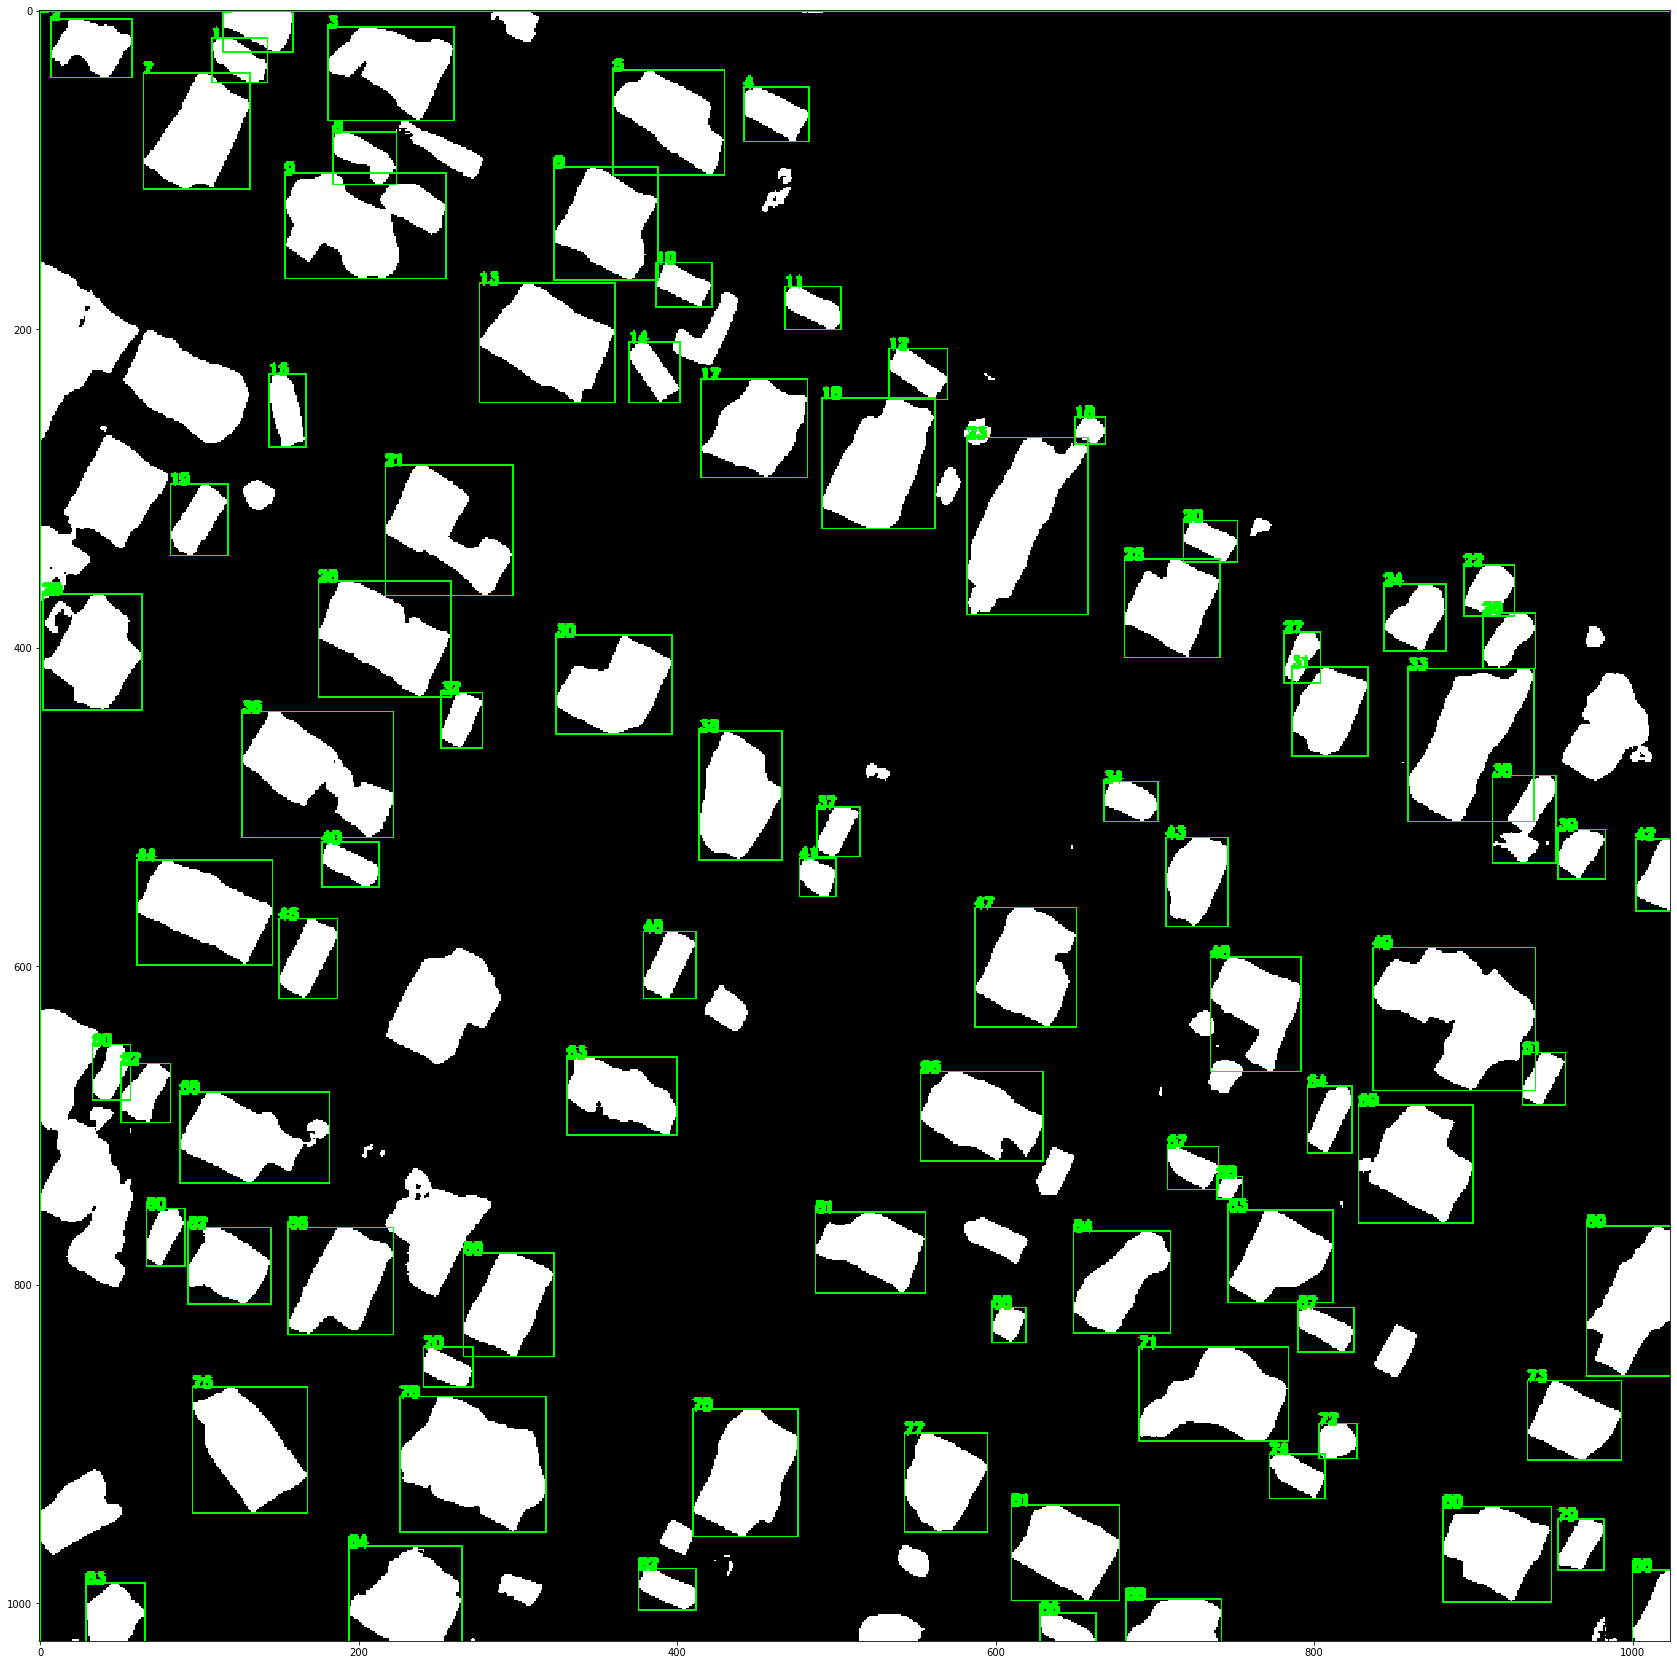

In [47]:
image_pre_bbox = cv2.imread(IMAGE_PRE)

    

for n in range(0,len(t)):
    topleft_x,topleft_y,bottom_right_x,bottom_right_y= bbox_predicho[t[n]]
    
    cv2.rectangle(image_pre_bbox,(topleft_x, topleft_y),(bottom_right_x, bottom_right_y),color=(0, 255, 0), thickness=1)
    cv2.putText(image_pre_bbox, str(n), (topleft_x, topleft_y),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 2)
    cv2.rectangle(image_ori_bbox,(topleft_x, topleft_y),(bottom_right_x, bottom_right_y),color=(0,255, 0, 0), thickness=1)
    cv2.putText(image_ori_bbox, str(n), (topleft_x, topleft_y),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,255, 0), 2)

plt.figure(figsize=(30,30))
plt.imshow(image_pre_bbox)

In [48]:
t=df_predicho.index[(df_predicho['BLANCOS_INV']==0) & (df_predicho['SUPERFICIE']>5) ]
tp=df_predicho[df_predicho['BLANCOS_INV']==0]

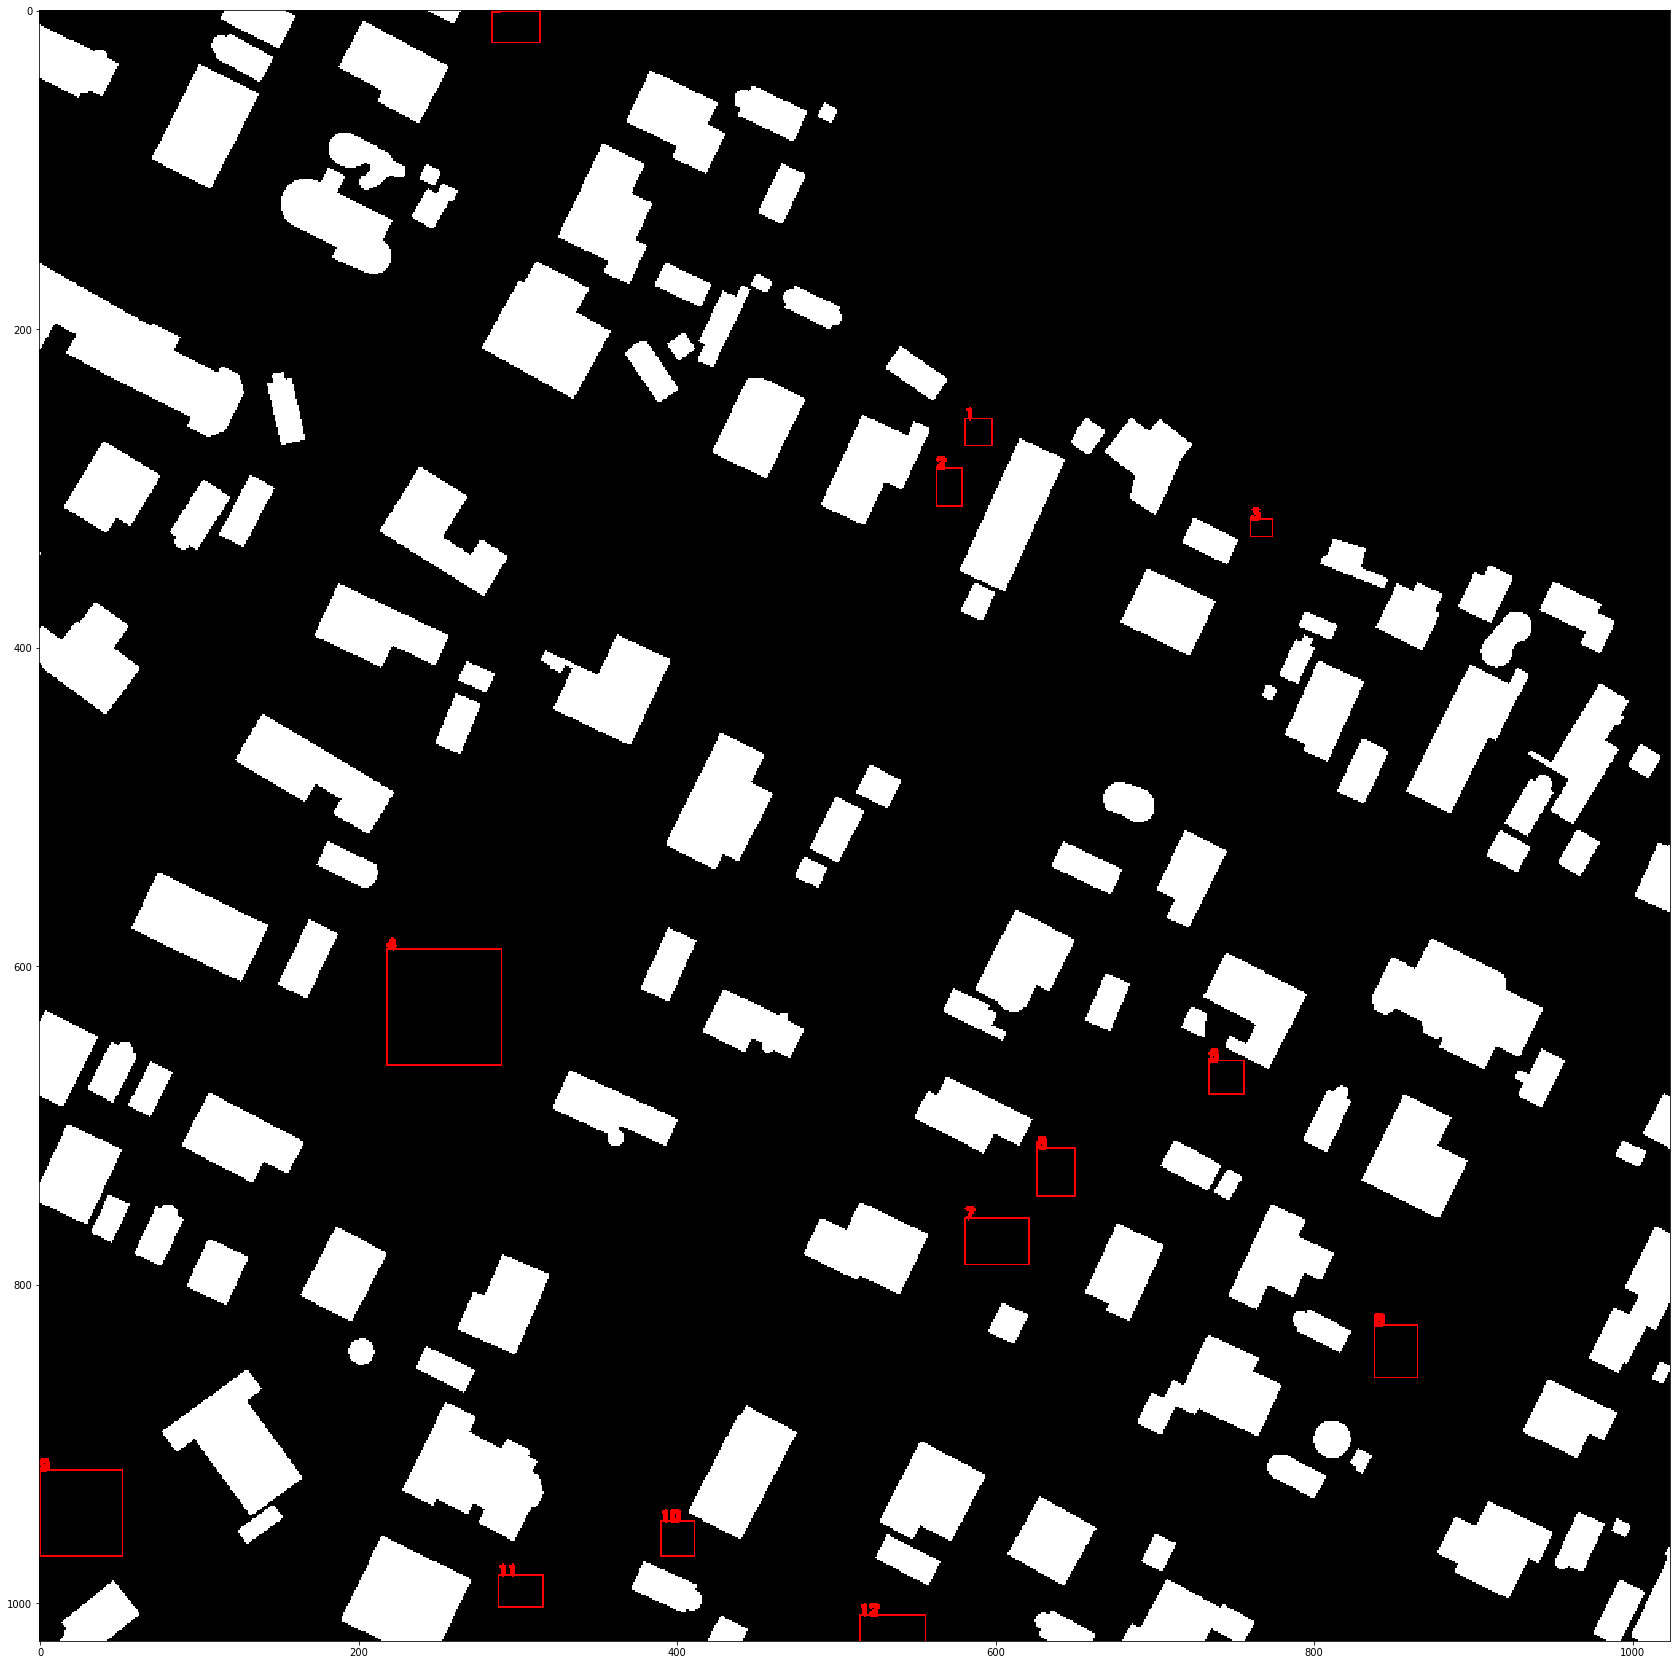

In [49]:
image_pre_bbox = cv2.imread(IMAGE_ORI)

    

for n in range(0,len(t)):
    topleft_x,topleft_y,bottom_right_x,bottom_right_y= bbox_predicho[t[n]]
    
    cv2.rectangle(image_pre_bbox,(topleft_x, topleft_y),(bottom_right_x, bottom_right_y),color=(255, 0, 0), thickness=1)
    cv2.putText(image_pre_bbox, str(n), (topleft_x, topleft_y),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 2)
    cv2.rectangle(image_ori_bbox,(topleft_x, topleft_y),(bottom_right_x, bottom_right_y),color=(255, 0, 0), thickness=1)
    cv2.putText(image_ori_bbox, str(n), (topleft_x, topleft_y),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 2)

plt.figure(figsize=(30,30))
plt.imshow(image_pre_bbox)

In [50]:
int(t[0])

2

In [51]:
df_predicho[df_predicho.index==104]

,BBOX,ANCHO,ALTO,IOU,BOX_CRUCE,ACC,SUPERFICIE,BLANCOS_INV,ESTADO
104,"[203, 712, 210, 721]",7,9,0.0,-1,57.142857,1.6875,0.0,NaN


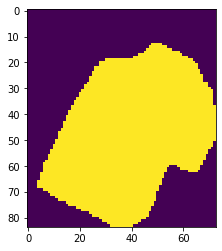

In [52]:
recorte=data_predicha[576:660,214:287]
plt.imshow(recorte)

In [53]:
x,y=np.unique(recorte,return_counts=True)
y

array([2982, 3150], dtype=int64)

In [54]:
3661*0.0625


228.8125

In [55]:
recorte[0,0]

0

In [56]:
80*60*0.25


1200.0

In [57]:
256/0.25


1024.0

In [58]:
0.25*0.25


0.0625

In [59]:
df_predicho

,BBOX,ANCHO,ALTO,IOU,BOX_CRUCE,ACC,SUPERFICIE,BLANCOS_INV,ESTADO
0,"[476, 0, 493, 2]",17,2,0.00,-1,14.705882,1.8125,0.0000,NaN
1,"[495, 0, 496, 1]",1,1,0.00,-1,0.000000,0.0625,0.0000,NaN
2,"[284, 0, 314, 20]",30,20,0.00,-1,36.000000,24.0000,0.0000,NaN
3,"[115, 0, 159, 26]",44,26,0.87,1,82.167832,57.8750,52.5000,NaN
4,"[108, 17, 143, 45]",35,28,0.84,2,72.653061,40.0000,42.0000,NaN
...,...,...,...,...,...,...,...,...,...
159,"[21, 1023, 25, 1024]",4,1,0.01,129,100.000000,0.2500,0.2500,NaN
160,"[271, 1022, 274, 1024]",3,2,0.00,-1,33.333333,0.2500,0.0000,NaN
161,"[0, 0, 1024, 1024]",1024,1024,1.00,132,92.619896,11121.5000,10398.5000,NaN
162,"[682, 997, 742, 1024]",60,27,0.51,130,91.172840,75.3750,79.0625,NaN


In [60]:
189-63-88


38

In [61]:
newdf=df_predicho.drop(tp.index)
ndf=newdf.drop(df_correcto.index)

In [62]:
t=ndf.index[ndf['SUPERFICIE']>5]

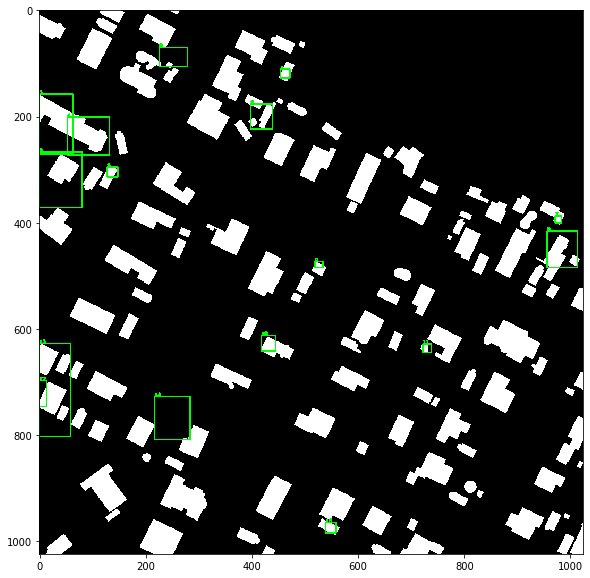

In [63]:
image_pre_bbox2 = cv2.imread(IMAGE_ORI)
image_ori_bbox = cv2.imread(IMAGE_ORI)
    

for n in range(0,len(t)):
    topleft_x,topleft_y,bottom_right_x,bottom_right_y= bbox_predicho[t[n]]
    image_pre_bbox = cv2.imread(IMAGE_PRE)
    cv2.rectangle(image_pre_bbox2,(topleft_x, topleft_y),(bottom_right_x, bottom_right_y),color=(0, 255, 0), thickness=2)
    cv2.putText(image_pre_bbox2, str(n), (topleft_x, topleft_y),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 2)
    #cv2.rectangle(image_ori_bbox,(topleft_x, topleft_y),(bottom_right_x, bottom_right_y),color=(0,255, 0, 0), thickness=1)
    #cv2.putText(image_ori_bbox, str(n), (topleft_x, topleft_y),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,255, 0), 2)

plt.figure(figsize=(10,10))
plt.imshow(image_pre_bbox2)
#plt.imshow(image_ori_bbox)

In [64]:
t=ndf.index[(ndf['SUPERFICIE']>5) & (ndf['ACC']<50)]


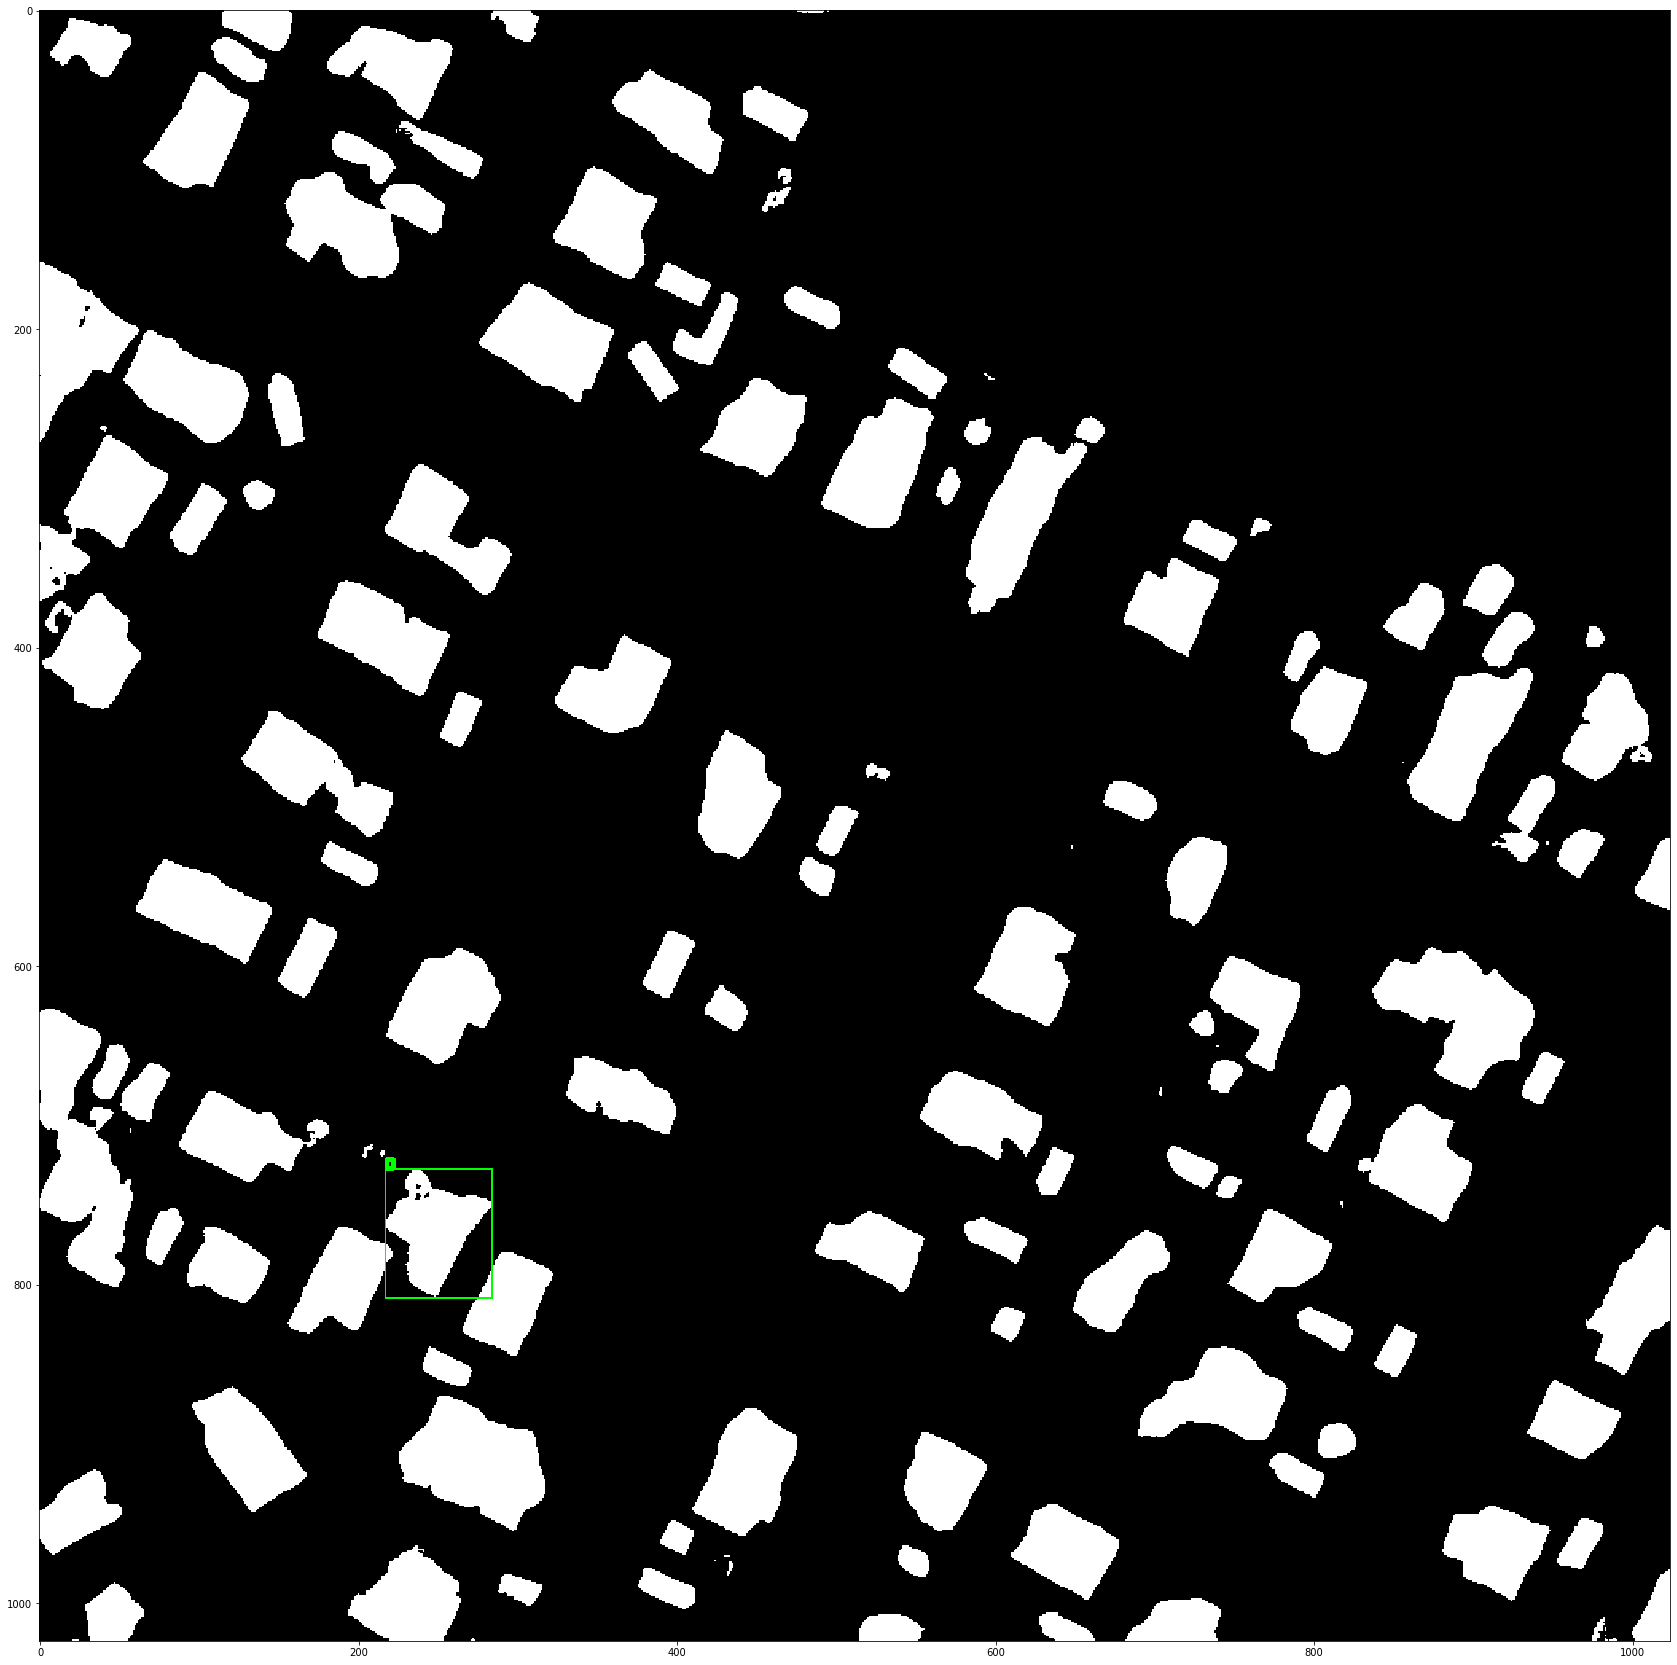

In [65]:
image_pre_bbox2 = cv2.imread(IMAGE_PRE)
image_ori_bbox = cv2.imread(IMAGE_ORI)
    

for n in range(0,len(t)):
    topleft_x,topleft_y,bottom_right_x,bottom_right_y= bbox_predicho[t[n]]
    image_pre_bbox = cv2.imread(IMAGE_PRE)
    cv2.rectangle(image_pre_bbox2,(topleft_x, topleft_y),(bottom_right_x, bottom_right_y),color=(0, 255, 0), thickness=1)
    cv2.putText(image_pre_bbox2, str(n), (topleft_x, topleft_y),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 2)
    #cv2.rectangle(image_ori_bbox,(topleft_x, topleft_y),(bottom_right_x, bottom_right_y),color=(0,255, 0, 0), thickness=1)
    #cv2.putText(image_ori_bbox, str(n), (topleft_x, topleft_y),cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,255, 0), 2)

plt.figure(figsize=(30,30))
plt.imshow(image_pre_bbox2)
#plt.imshow(image_ori_bbox)

In [66]:
data_original

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

In [67]:
df_original.shape[0]

133

In [68]:
t=df_predicho.index

In [69]:
t[0]

0

Text(0.5, 1.0, 'Original bbox')

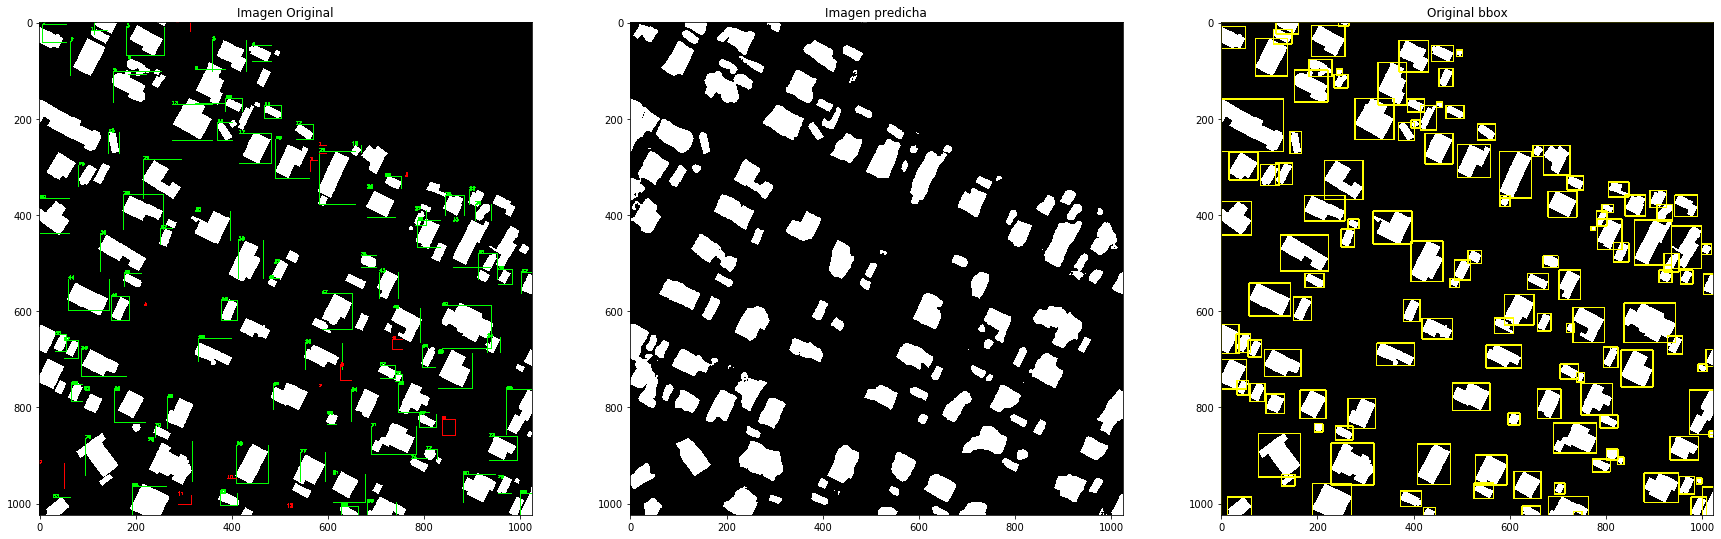

In [70]:
plt.figure(figsize=(30,30))

plt.subplot(131)
plt.imshow(im_ori)
plt.title('Imagen Original')

plt.subplot(132)
plt.imshow(im_pre)
plt.title('Imagen predicha')

plt.subplot(133)
plt.imshow(imagen_original_bbox)
plt.title('Original bbox')

In [71]:
len(original_nocruza)

26